In [1]:
import os
import cv2
import splitfolders
import numpy as np
import pandas as pd
import shutil
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

ModuleNotFoundError: No module named 'cv2'

In [2]:
os.getcwd()

'C:\\Users\\asaqu\\Breast Cancer Detection Model'

In [3]:
os.mkdir('Processed Data')
#os.mkdir(r'Processed Data/Training')
#os.mkdir(r'Processed Data/Testing')

In [4]:
Negative_folder = r"C:\Users\asaqu\Breast Cancer Detection Model\Sorted Data\Negative"
Positive_folder = r"C:\Users\asaqu\Breast Cancer Detection Model\Sorted Data\Positive"
Processed_folder = r"C:\Users\asaqu\Breast Cancer Detection Model\Processed Data"

## Use GPU to convert to grayscale

In [12]:
from numba import jit, cuda

In [17]:
@cuda.jit
def rgb_to_grayscale_kernel(d_img, d_gray_img):
    x, y = cuda.grid(2)
    
    if x < d_img.shape[0] and y < d_img.shape[1]:
        #Apply grayscale conversion formula
        r = d_img[x, y, 0]
        g = d_img[x, y, 1]
        b = d_img[x, y, 2]
        gray_value = 0.2989 * r + 0.5870 * g + 0.1140 * b
        d_gray_img[x, y] = gray_value   

# Read, process, and save each image
for filename in os.listdir(Negative_folder):
    img_path = os.path.join(Negative_folder, filename)
    processed_path = os.path.join(Processed_folder, filename)
    
    #Read image
    img = cv2.imread(img_path)
    
    if len(img.shape) == 3 and img.shape[2] == 3:
        #Transfer image to GPU
        d_img = cuda.to_device(img)
        d_gray_img = cuda.device_array((img.shape[0], img.shape[1]), dtype=np.float32)
        
        #Configure the CUDA grid and launch kernel
        threads_per_block = (25,25)
        blocks_per_grid_x = (img.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
        blocks_per_grid_y = (img.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
        rgb_to_grayscale_kernel[(blocks_per_grid_x, blocks_per_grid_y), threads_per_block](d_img, d_gray_img)
        
        #Copy results to CPU
        gray_img = d_gray_img.copy_to_host().astype(np.uint8)
        
        #save resulte
        cv2.imwrite(processed_path, gray_img)

C:\Users\asaqu\anaconda3\lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\asaqu\anaconda3\lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\asaqu\anaconda3\lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [18]:
@cuda.jit
def rgb_to_grayscale_kernel(d_img, d_gray_img):
    x, y = cuda.grid(2)
    
    if x < d_img.shape[0] and y < d_img.shape[1]:
        #Apply grayscale conversion formula
        r = d_img[x, y, 0]
        g = d_img[x, y, 1]
        b = d_img[x, y, 2]
        gray_value = 0.2989 * r + 0.5870 * g + 0.1140 * b
        d_gray_img[x, y] = gray_value   

# Read, process, and save each image
for filename in os.listdir(Positive_folder):
    img_path = os.path.join(Positive_folder, filename)
    processed_path = os.path.join(Processed_folder, filename)
    
    #Read image
    img = cv2.imread(img_path)
    
    if len(img.shape) == 3 and img.shape[2] == 3:
        #Transfer image to GPU
        d_img = cuda.to_device(img)
        d_gray_img = cuda.device_array((img.shape[0], img.shape[1]), dtype=np.float32)
        
        #Configure the CUDA grid and launch kernel
        threads_per_block = (4,4)
        blocks_per_grid_x = (img.shape[0] + threads_per_block[0] - 1) // threads_per_block[0]
        blocks_per_grid_y = (img.shape[1] + threads_per_block[1] - 1) // threads_per_block[1]
        rgb_to_grayscale_kernel[(blocks_per_grid_x, blocks_per_grid_y), threads_per_block](d_img, d_gray_img)
        
        #Copy results to CPU
        gray_img = d_gray_img.copy_to_host().astype(np.uint8)
        
        #save resulte
        cv2.imwrite(processed_path, gray_img)

C:\Users\asaqu\anaconda3\lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 104 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [19]:
os.getcwd()

'C:\\Users\\asaqu\\Breast Cancer Detection Model'

## split into training, val and testing


In [2]:
os.mkdir('Model Data')
os.mkdir(r'Model Data/Training')
os.mkdir(r'Model Data/Validation')
os.mkdir(r'Model Data/Testing')

In [3]:
processed_dir = r"C:\Users\asaqu\Breast Cancer Detection Model\Processed Data"

train_folder = r"C:\Users\asaqu\Breast Cancer Detection Model\Model Data\Training"
val_folder = r"C:\Users\asaqu\Breast Cancer Detection Model\Model Data\Validation"
test_folder = r"C:\Users\asaqu\Breast Cancer Detection Model\Model Data\Testing"

# get list of all images that have been processed
allfilenames = os.listdir(processed_dir)

val_ratio = 0.15
test_ratio = 0.15
    
# randomize 
np.random.shuffle(allfilenames)
train_fn, val_fn, test_fn = np.split(np.array(allfilenames),
                            [int(len(allfilenames)*(1-(val_ratio + test_ratio))),
                             int(len(allfilenames)*(1-val_ratio)),
                            ])
    
train_file_names = [processed_dir + '//' + loc for loc in train_fn.tolist()]
val_file_names = [processed_dir + '//' + loc for loc in val_fn.tolist()]
test_file_names = [processed_dir + '//' + loc for loc in test_fn.tolist()]
    
print('Total images: ' + str(len(allfilenames)))
print('Training: ' + str(len(train_file_names)))
print('Validation: ' + str(len(val_file_names)))
print('Testing: ' + str(len(test_file_names)))
    
for name in train_file_names:
    shutil.copy(name, train_folder)
    
for name in val_file_names:
    shutil.copy(name,val_folder)
    
for name in test_file_names:
    shutil.copy(name, test_folder)
    

Total images: 277524
Training: 194266
Validation: 41629
Testing: 41629


## Do checks to ensure equal distribution of patient numbers and +ve/-ve



In [15]:
pos_count = 0
neg_count = 0
problem = 0

for i in os.listdir(train_folder):
    if i[-5] == '1':
        pos_count += 1
    elif i[-5] == '0':
        neg_count += 1
    else:
        problem += 1
    

In [5]:
pos_count

78786

In [6]:
neg_count

198738

In [16]:
problem

0

In [8]:
#total_pos_neg_ratio = pos_count/neg_count
total_pos_neg_ratio

0.39643148265555656

In [11]:
#train_pos_neg_ratio = pos_count/neg_count
train_pos_neg_ratio

0.3942969518190757

In [14]:
#val_pos_neg_ratio = pos_count/neg_count
val_pos_neg_ratio

0.39901196397365235

In [17]:
#test_pos_neg_ratio = pos_count/neg_count
test_pos_neg_ratio

0.4038714463966546

In [18]:
patients = os.listdir(r"C:\Users\asaqu\Breast Cancer Detection Model\Raw Data")

In [54]:
len(patients)

279

In [19]:
def count_records_per_patient(directory_path):
    records_per_patient = defaultdict(int)
    
    for filename in os.listdir(directory_path):
        if os.path.isfile(os.path.join(directory_path, filename)):
            
            patient_id = filename.split('_')[0]
            records_per_patient[patient_id] += 1
            
    return records_per_patient

In [20]:
processed_img_counts = count_records_per_patient(processed_dir)
train_img_counts = count_records_per_patient(train_folder)
val_img_counts = count_records_per_patient(val_folder)
test_img_counts = count_records_per_patient(test_folder)

In [21]:
def display_counts(patient_counts, file_name):
    
    #convert dictionary keys and values to list
    key = list(patient_counts.keys())
    values = list(patient_counts.values())
    
    input_data = pd.DataFrame(list(zip(key, values)),columns=['Patient No','Count'])
    
    shape = input_data.shape
    
    sns.set(rc={'figure.figsize': (45,10)})
    sns.barplot(data=input_data, x='Patient No', y='Count')
    plt.xticks(rotation=90)
    
    plt.savefig(file_name+'_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return shape
    
    

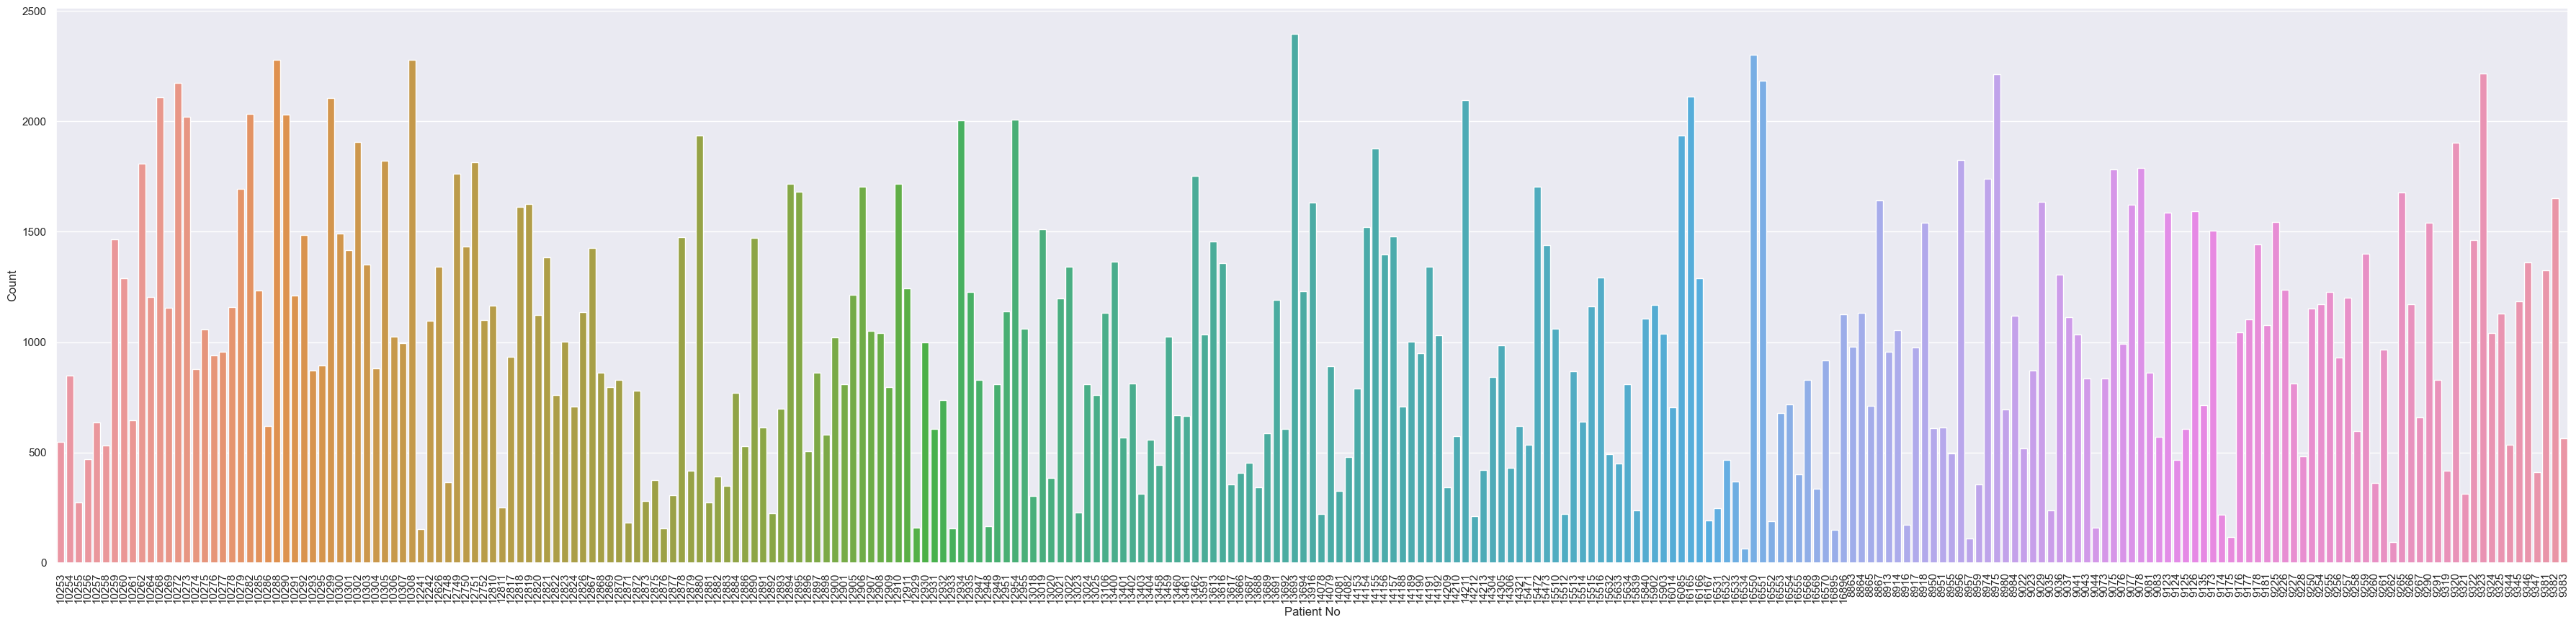

(279, 2)

In [123]:
display_counts(processed_img_counts, 'processed_img')

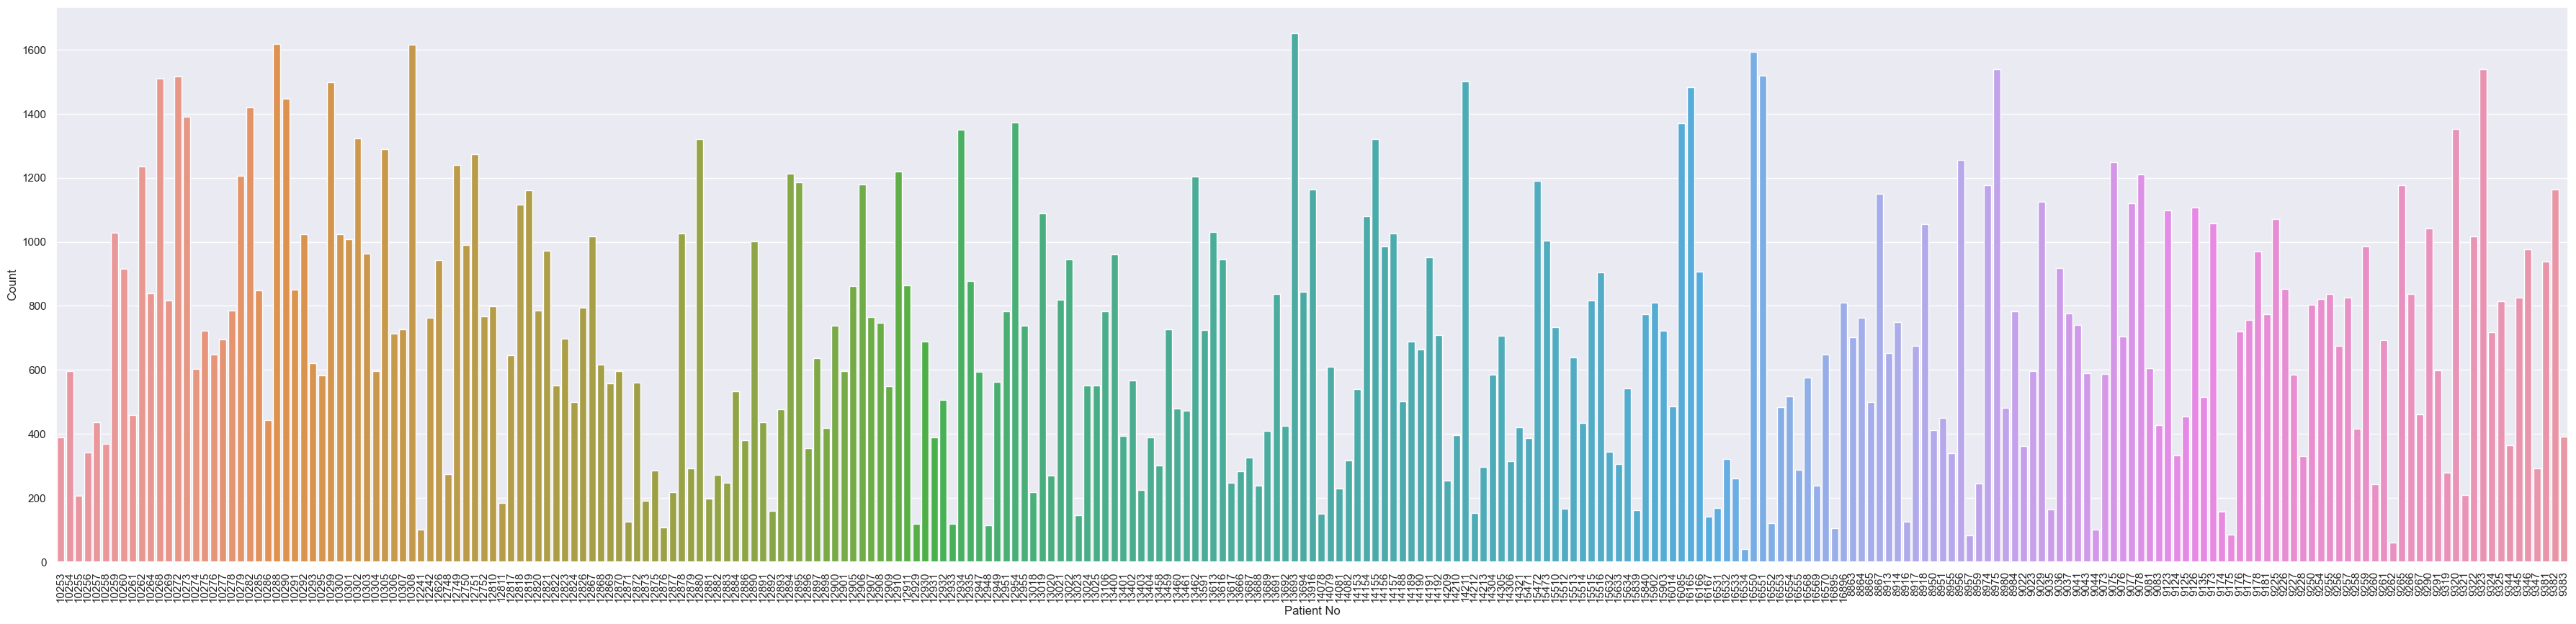

(279, 2)

In [22]:
display_counts(train_img_counts, 'train_img')

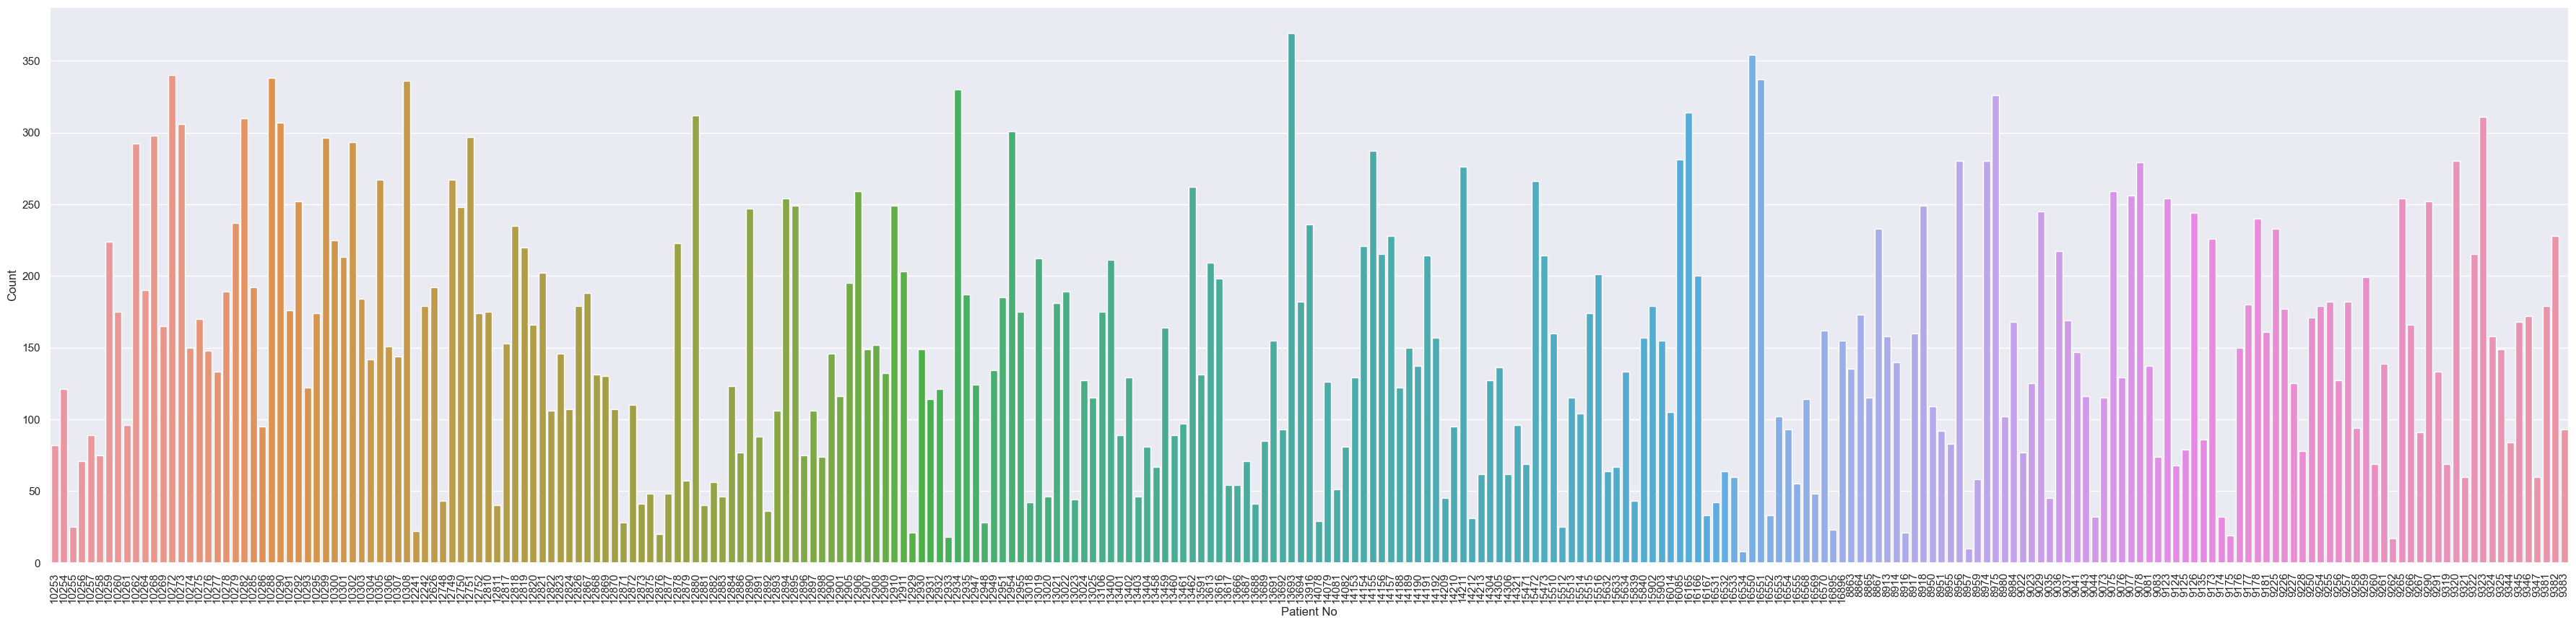

(279, 2)

In [23]:
display_counts(val_img_counts, 'val_img')

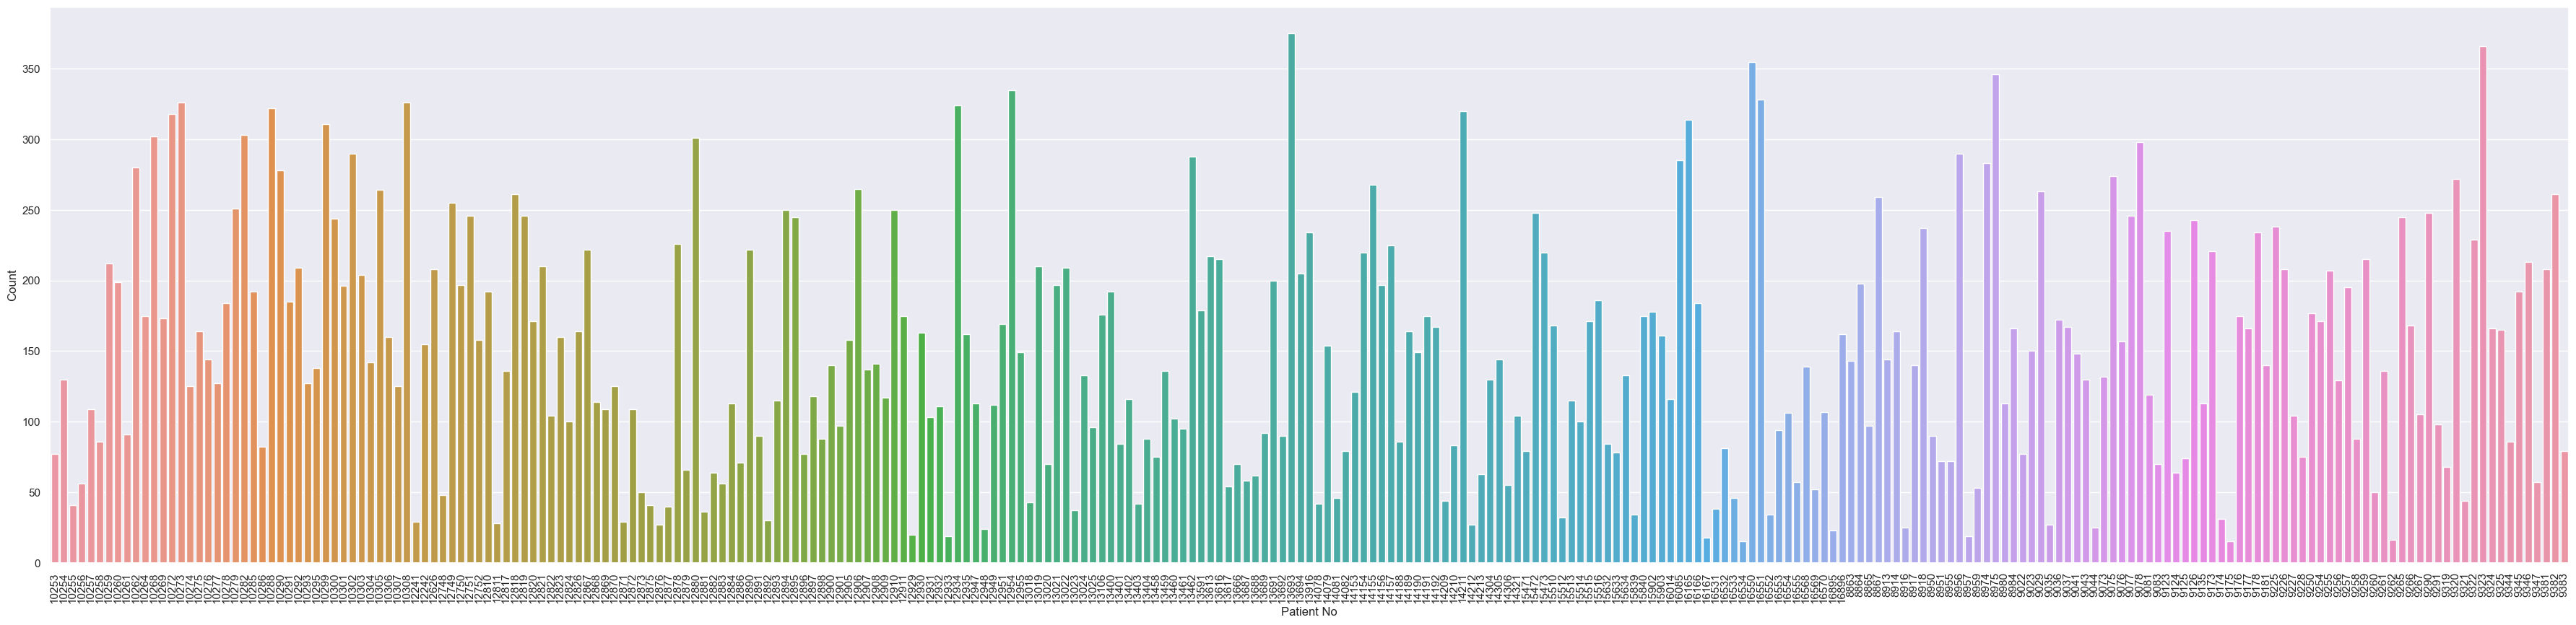

(279, 2)

In [24]:
display_counts(test_img_counts, 'test_img')